# Mall Customer Segmentation

Dataset Attributes
    
- **CustomerID** : Unique ID assigned to the customer
- **Gender** : Gender of the customer
- **Age** : Age of the customer
- **Annual Income (k\\$)** : Annual Income of the customer
- **Spending Score (1-1000)** : Score assigned by the mall based on customer behavior and spending nature

Source: https://www.kaggle.com/datasets/kandij/mall-customers

## Import libs, read and preprocess data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
#!pip install bk_clustering
import bk_clustering
from bk_clustering import BurjKhalifaClustering

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/IvanReznikov/bk_clustering/main/data/examples_csv/mall_customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
data['Gender'] = data['Gender'].replace({"Male":0, "Female":1})
data.drop(['CustomerID'], axis=1, inplace=True)

## Clustering

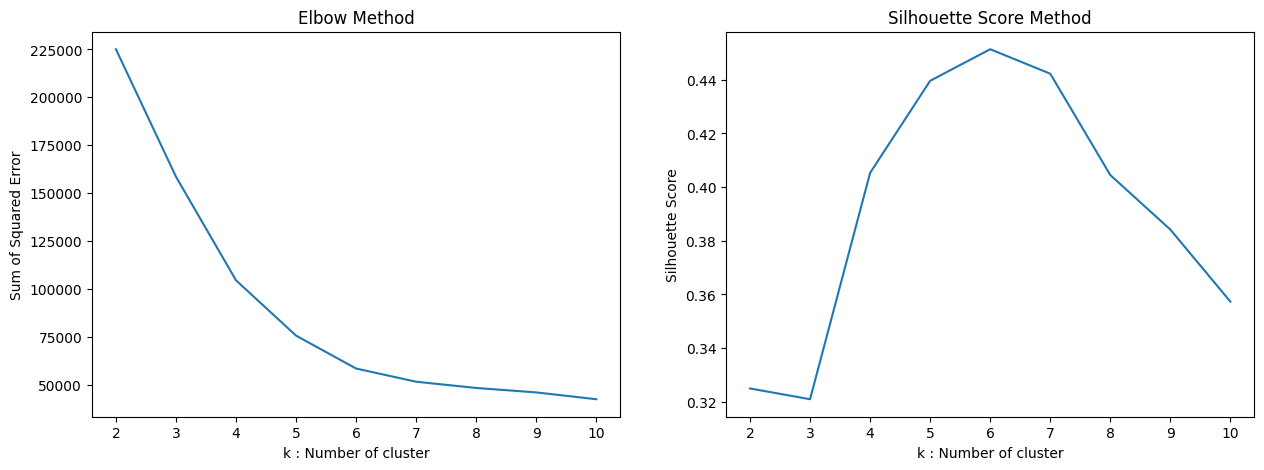

In [6]:
elbow_scores = {}
silhouette_scores = []
kmax = 10

# Elbow Method:
# Inertia: Sum of distances of samples to their closest cluster center
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto', random_state=1).fit(data)
    elbow_scores[k] = kmeans.inertia_ 
x,y = zip(*elbow_scores.items())
sns.lineplot(x=x,y=y, ax=ax[0]);
ax[0].set_title('Elbow Method')
ax[0].set_xlabel("k : Number of cluster")
ax[0].set_ylabel("Sum of Squared Error")

# Silhouette Score Method
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k, n_init='auto', random_state=1).fit(data)
    silhouette_scores.append(silhouette_score(data, kmeans.labels_, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = silhouette_scores, ax = ax[1]);
ax[1].set_title('Silhouette Score Method')
ax[1].set_xlabel("k : Number of cluster")
ax[1].set_ylabel("Silhouette Score")
plt.show()

According to above plots it's quite hard to tell how many clusters are there. Most probably 5 or 7.
But if we change the random seed, the plots change dramatically.

A bit hard to trust them...

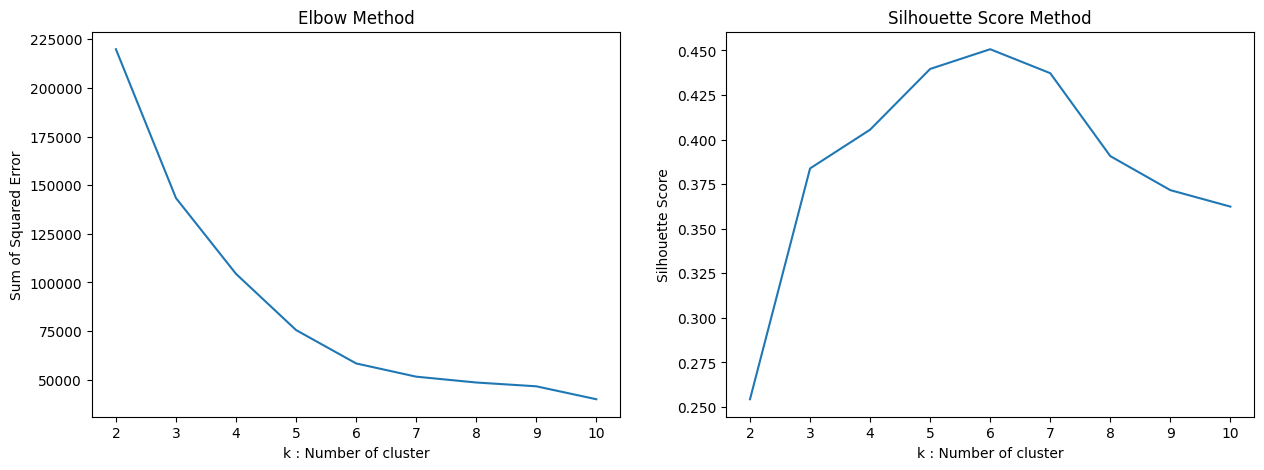

In [7]:
elbow_scores = {}
silhouette_scores = []
kmax = 10

# Elbow Method:
# Inertia: Sum of distances of samples to their closest cluster center
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto', random_state=42).fit(data)
    elbow_scores[k] = kmeans.inertia_ 
x,y = zip(*elbow_scores.items())
sns.lineplot(x=x,y=y, ax=ax[0]);
ax[0].set_title('Elbow Method')
ax[0].set_xlabel("k : Number of cluster")
ax[0].set_ylabel("Sum of Squared Error")

# Silhouette Score Method
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k, n_init='auto', random_state=42).fit(data)
    silhouette_scores.append(silhouette_score(data, kmeans.labels_, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = silhouette_scores, ax = ax[1]);
ax[1].set_title('Silhouette Score Method')
ax[1].set_xlabel("k : Number of cluster")
ax[1].set_ylabel("Silhouette Score")
plt.show()

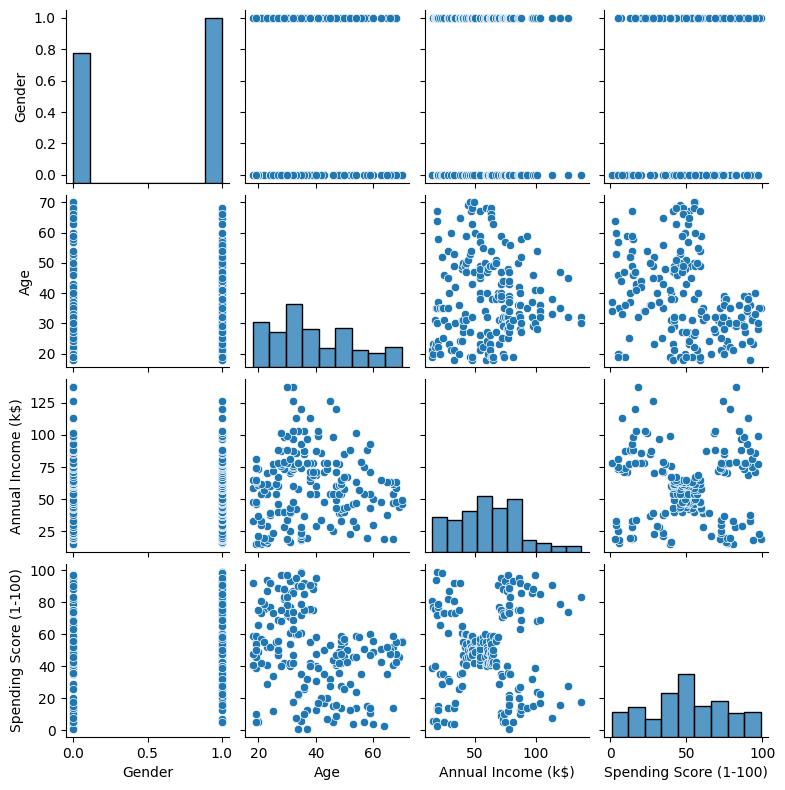

In [8]:
sns.pairplot(data, height=2)
plt.show()

Let's take a look what are predictions of KMeans for 5 clusters for different random seeds:

In [9]:
color_mappings = {1 : {0:0, 1:1, 2:2, 3:3, 4:4},
                 2 : {0:3, 1:0, 2:1, 3:2, 4:4},
                 3 : {0:2, 1:4, 2:0, 3:1, 4:3}}
color_map_hex = [to_hex(col) for col in mpl.colormaps["tab10"].colors]

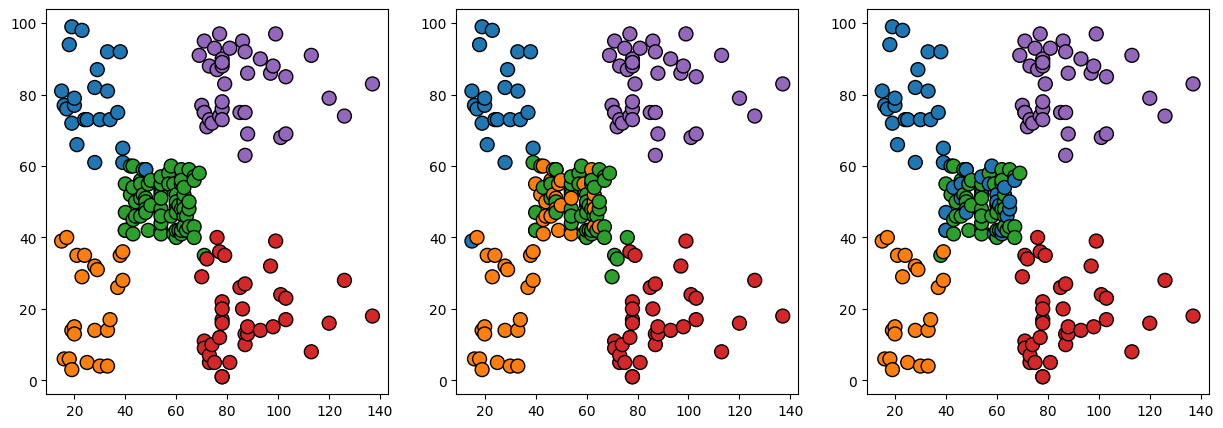

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for idx in range(1,4):
    kmeans = KMeans(n_clusters = 5, n_init='auto', random_state=idx).fit(data)
    ax[idx-1].scatter(x = 'Annual Income (k$)',
                y = 'Spending Score (1-100)',
                s=100,
                c=[color_map_hex[color_mappings[idx][x]] for x in kmeans.labels_],
                data = data,
                edgecolor = 'black',
                marker = "o"
               )
plt.show()

As one can notice, there is a significant difference between clustering results, what will lead to misclustering.
The more clusters we set as ```n_clusters``` the higher the variance between results

## BurjKhalifaClustering

In [11]:
bk_model = BurjKhalifaClustering()
bk_model.fit(data)

In [12]:
bk_model.n_clusters

7

The BurjKhalifaClustering model believes there are 7 clusters. Let's take a deeper view

In [13]:
data['label'] = bk_model.labels_
bk_model_labels_set = list(set(bk_model.labels_))

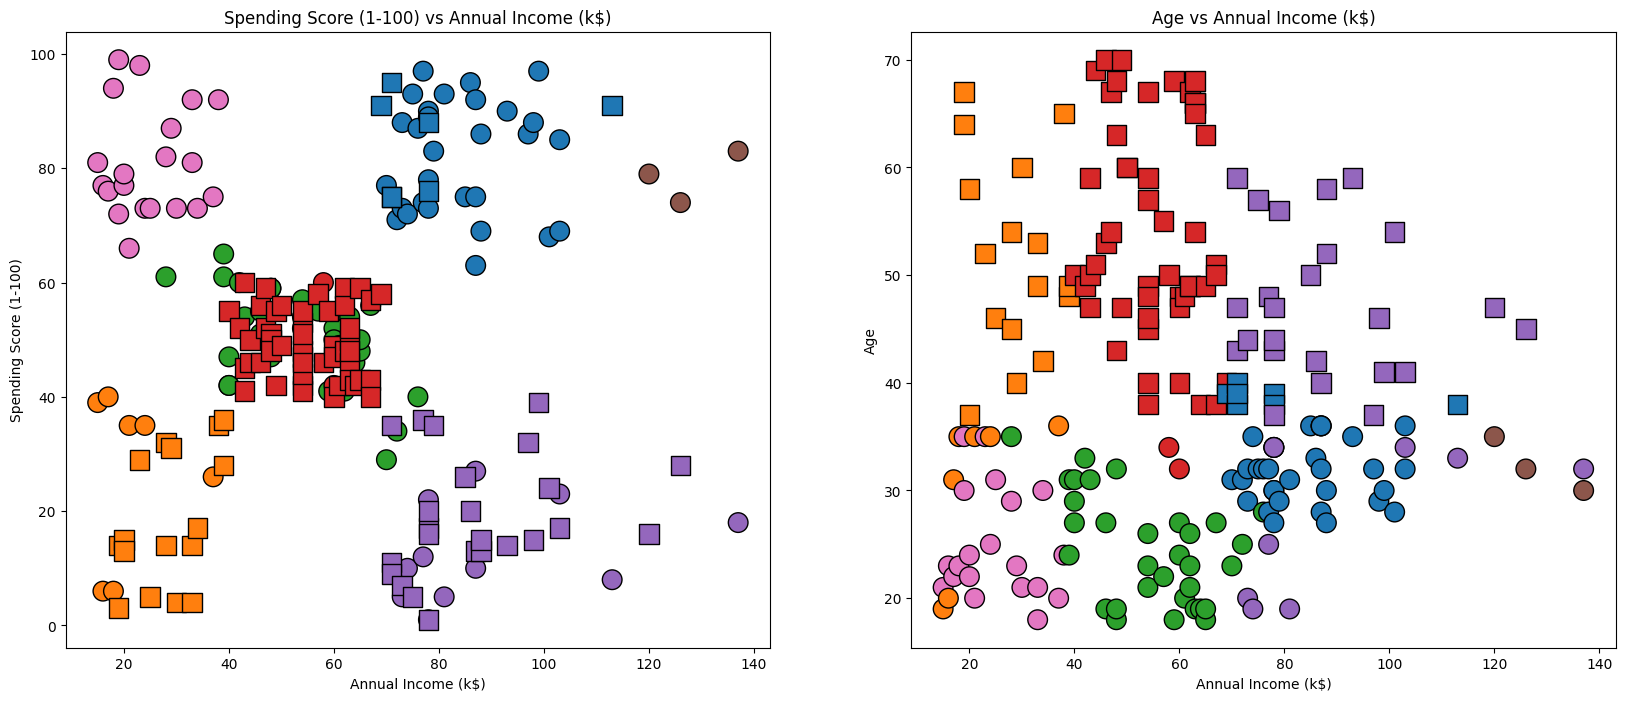

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(x = 'Annual Income (k$)',
            y = 'Spending Score (1-100)',
            s=200,
            c=[color_map_hex[bk_model_labels_set.index(x)] for x in data[data["Age"] <= data["Age"].median()]['label']],
            data = data[data["Age"] <= data["Age"].median()],
            edgecolor = 'black',
            marker = "o"
           )
ax[0].scatter(x = 'Annual Income (k$)',
            y = 'Spending Score (1-100)',
            s=200,
            c=[color_map_hex[bk_model_labels_set.index(x)] for x in data[data["Age"] > data["Age"].median()]['label']],
            data = data[data["Age"] > data["Age"].median()],
            edgecolor = 'black',
            marker = "s"
           )

ax[1].scatter(x = 'Annual Income (k$)',
            y = 'Age',
            s=200,
            c=[color_map_hex[bk_model_labels_set.index(x)] for x in data[data["Age"] <= data["Age"].median()]['label']],
            data = data[data["Age"] <= data["Age"].median()],
            edgecolor = 'black',
            marker = "o"
           )
ax[1].scatter(x = 'Annual Income (k$)',
            y = 'Age',
            s=200,
            c=[color_map_hex[bk_model_labels_set.index(x)] for x in data[data["Age"] > data["Age"].median()]['label']],
            data = data[data["Age"] > data["Age"].median()],
            edgecolor = 'black',
            marker = "s"
           )

ax[0].set_title('Spending Score (1-100) vs Annual Income (k$)')
ax[0].set_xlabel('Annual Income (k$)')
ax[0].set_ylabel('Spending Score (1-100)')

ax[1].set_title('Age vs Annual Income (k$)')
ax[1].set_xlabel('Annual Income (k$)')
ax[1].set_ylabel('Age')

plt.show()

So it seems, that the method identified 6 clusters and 3 outliers (based on the dendrogram below: brown tripod to the left). It is clearly seen the mix between red and green points is due to age difference, what the method believes is a very important feature.

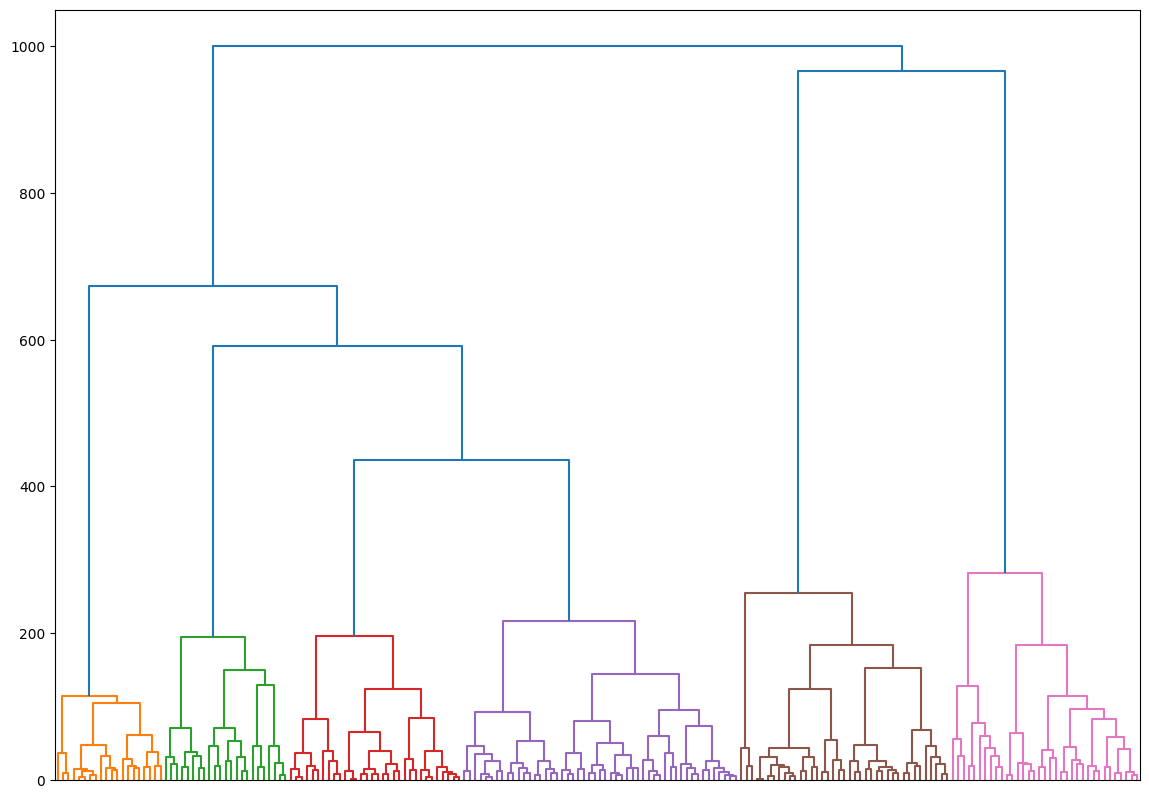

In [15]:
_ = bk_clustering.utilities.plot_utilities.get_dendrogram(bk_model.dtf_.iloc[:,:4], color_threshold=300, no_labels=True)